# Mini Project 4

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

In the lectures we explored how to delta hedge sold call options, resulting in a trading strategy whose profits are neutral to upward or downward drift in a stock path movements, provided the volatility, or $\sigma$, of the stock remained constant.

For this final mini project explore the impact of a non-constant $\sigma$ on the distribution of profits of hedging. You are also encouraged to explore/research a $\sigma$-hedging strategy and write code that simulates the profit distribution of the $\sigma$-hedging strategy. 

Below is some code you can customize that simulates a stock path whose $\sigma$ is not constant.

You are encouraged to use a different model for sigma than the one provided. You can use stock paths simulated by Heston model? You could use a GARCH model for volatility. The choice is yours and you can do your own research to choose how to model a stock movement. 

In [11]:
#Package Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import shapiro
import scipy.stats as stats
from scipy.optimize import brentq
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import quad
from scipy.optimize import minimize
from joblib import Parallel, delayed
from scipy.stats import rv_discrete
from statsmodels.stats.diagnostic import acorr_ljungbox
from functions import *
sns.set_style('darkgrid')

In [12]:
def stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps):
    '''
    Generation of custom stock paths following Geometeric Brownian motion,
    but log-returns do not have constant volatility.
    
    Each step of the log-returns, there is a 
    1) 50% the volatility is .2
    2) 30% chance the volatility is .3
    3) 20% chance the volatility is .45
    
    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path
    
    Returns:
    
    Simuatled stock paths
    '''
    
    #Noise in volatility
    noise = np.random.normal(0,1,size = (n_paths, n_steps))
    
    #Custom sigma that is not constant
    sigma = np.random.choice([.2,.3,.45], p = [.5, .3, .2], size = (n_paths, n_steps))
    
    #Time increment between each step
    dt = t/n_steps
    
    #log-returns between each step
    increments = (mu + r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise
    
    #Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis = 1)
    
    
    #paths
    paths = S0*np.exp(log_returns)
    
    
    #Adjoint initial value S0 at start of each simulated path
    paths = np.insert(paths, 0, S0, axis = 1)
    
    
    return paths
    
    

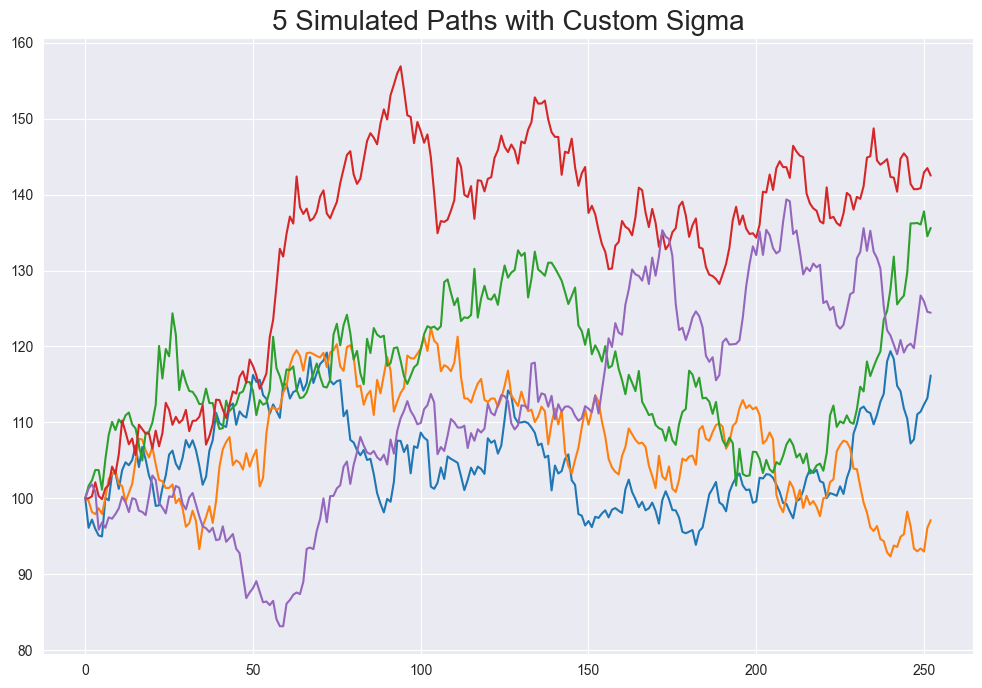

In [13]:
#5 Simulated paths of daily steps over 1-year period and plot

S0 = 100
t = 1
r = 0.039
mu = 0.275
n_paths = 5
n_steps = 252


simulated_paths = stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps)


plt.figure(figsize = (12,8))

for path in simulated_paths:
    plt.plot(path)
    
plt.title(f'{n_paths} Simulated Paths with Custom Sigma', size = 20)


plt.show()

In [14]:
##Functions for option data obtained through y-finance

from dateutil import parser
from dateutil.tz import tzutc

def find_tte_yf_options(expiration_date,last_trade_date):
    '''returns time measured in years as a float between two dates
    
    Inputs:
    expiration_date (str): 'YYYY-MM-DD'
    last_trade_date (pandas._libs.tslibs.timestamps.Timestamp)
    
    Returns:
    Float of time to expiration in years
    '''
    tte = (datetime.datetime.strptime(expiration_date+'-21-30', "%Y-%m-%d-%H-%M").replace(tzinfo=tzutc()) -\
last_trade_date).total_seconds()/(60*60*24*365)
    
    return tte


def yf_find_approx_spot(stock_data, last_trade_date):
    """
    Finds approximate spot price at the time of last trade.
    The spot price is approximate since yfinance does not provide 1-second data, only minute-by-minute.

    Parameters:
    stock_data (pd.Series or pd.DataFrame): stock prices with DatetimeIndex
    last_trade_date (pd.Timestamp): timestamp of last trade of option contract

    Returns:
    float: approximate spot price, or NaN if unavailable
    """
    # Round timestamp to the minute (zero out seconds)
    ts = last_trade_date.replace(second=0)

    try:
        return stock_data.loc[ts].iloc[0]
    except KeyError:
        return float('nan')

In [15]:
# I combined the code from lecture into one function to preprocess historical data

def preprocessing(stock_symbol):
    ticker = yf.Ticker(stock_symbol)
    stock_data = yf.download(stock_symbol, period = '1d', interval = '1m')



    expirations = ticker.options


    #Create array to store options data
    option_data = []

    for date in expirations:
        chain = ticker.option_chain(date)

        # Add expiration and label
        calls = chain.calls.copy()
        calls['expiration'] = date
        calls['option_type'] = 'call'

        puts = chain.puts.copy()
        puts['expiration'] = date
        puts['option_type'] = 'put'

        option_data.append(calls)
        option_data.append(puts)

    # Combine all into one DataFrame and delete implied volatility column since we'll recalculate.
    options_data = pd.concat(option_data, ignore_index=True)
    options_data = options_data.drop(columns=['impliedVolatility'])


    #Delete any options that were traded in the interval of historical stock values obtained
    start_date = stock_data.index[0]
    options_data = options_data[options_data['lastTradeDate']>=start_date]


    #Insert column of time to expiration in years of the option contract measured from time of last trade
    options_data['time_to_expiration'] = options_data.apply(
    lambda row: find_tte_yf_options(expiration_date = row['expiration'],
                                last_trade_date = row['lastTradeDate']),
        axis = 1
    )


    #Add in column of the spot price of stock when the option trade occured.
    options_data['spot_price'] = options_data.apply(
        lambda row: yf_find_approx_spot(stock_data['Close'], row['lastTradeDate']),
        axis=1
    )
    options_data = options_data.dropna()





    #Create data frames that keeps relevant information and separate calls from puts.
    options_data = options_data[['strike', 'lastPrice', 'lastTradeDate',\
                                'expiration', 'option_type','time_to_expiration', 'spot_price']]
    options_data_calls = options_data[(options_data['option_type'] == 'call')].copy()
    options_data_puts = options_data[(options_data['option_type'] == 'put')].copy()



    #Add implied volatility column in calls data frame 
    r = 0.039
    options_data_calls['implied_volatility'] = options_data_calls.apply(
        lambda row: implied_volatility_call(
            market_price=row['lastPrice'],
            S0 = row['spot_price'],
            K=row['strike'],
            t=row['time_to_expiration'],
            r=r
        ),
        axis=1
    )


    #Add implied volatility column in puts data frame 
    options_data_puts['implied_volatility'] = options_data_puts.apply(
        lambda row: implied_volatility_put(
            market_price=row['lastPrice'],
            S0 = row['spot_price'],
            K=row['strike'],
            t=row['time_to_expiration'],
            r=r
        ),
        axis=1
    )

    #Remove rows with undefined values
    options_data_calls = options_data_calls.dropna()
    options_data_puts = options_data_puts.dropna()

    ## Remove additional rows if needed
    options_data_calls = options_data_calls[(options_data_calls['time_to_expiration']<=1)\
                                        & (options_data_calls['time_to_expiration']>=.5)]
    
    options_data_puts = options_data_puts[(options_data_puts['time_to_expiration']<=1)\
                                        & (options_data_puts['time_to_expiration']>=.5)]
    
    return options_data_calls, options_data_puts

In [16]:
# I combined the code from the lecture into this single function. This function calibrate Heston model to option data using gradient descent.
def calibrate_call(options_data_calls):

    def objective(params, option_data, r):
        kappa, theta, xi, rho, v0 = params
        
        error = 0
        for _, row in option_data.iterrows():
            model_price = heston_call(
                S0=row['spot_price'],
                K=row['strike'],
                v0=v0,
                r=r,
                t=row['time_to_expiration'],
                kappa=kappa,
                theta=theta,
                xi=xi,
                rho=rho
            )
            market_price = row['lastPrice']
            error += (model_price - market_price) ** 2
            
        return error / len(option_data)


    initial_guess = [1.0, 0.04, 0.3, -0.5, 0.04]  # kappa, theta, xi, rho, v0
    bounds = [(1e-4, 10), (1e-4, 1), (1e-4, 2), (-0.99, 0.99), (1e-4, 1)] 


    r = 0.039  

    result = minimize(
        objective,
        initial_guess,
        args=(options_data_calls, r),
        bounds=bounds,
        method='L-BFGS-B',
        options={
            'disp': True,
            'maxiter': 20,       
            'ftol': 1e-4,         
            'gtol': 1e-4          
        }
    )


    calibrated_params = result.x

    return calibrated_params

In [67]:
# This function simulates stock paths under the calibrated Heston model. Also, we hedge based on BS delta and vega along the way.
def run_heston_delta_vega_hedge(
    target_call,
    hedge_call,
    v0,
    kappa,
    theta,
    xi,
    rho,
    mu=0.0,
    n_sims=5000,
    n_steps=50,
    r=0.039
):
    """
    Delta and vega hedge simulation under Heston model.

    target_call : pd.Series
      one target call option row from the returned dataframe from "preprocessing" function above
    hedge_call : pd.Series
      one thedging call option row from the returned dataframe from "preprocessing" function above
    v0, kappa, theta, xi, rho, mu : floats
      calibrated Heston parameters
    n_sims : int
      number of Monte Carlo paths
    n_steps : int
      number of rebalancing dates
    r : float
      risk-free rate
    Returns
    total_pnl : np.ndarray of shape (n_sims,)
      P&L of the fully hedged position (you are short one target call)
    """

    # Check that both calls share the same expiration
    if target_call.expiration != hedge_call.expiration:
        raise ValueError("Target and hedge calls must have the same expiration date.")

    # Find spot, strikes, time to expiration
    S0 = float(target_call.spot_price)
    K_target = float(target_call.strike)
    T = float(target_call.time_to_expiration)

    K_hedge = float(hedge_call.strike)
    T_hedge = float(hedge_call.time_to_expiration)
    if abs(T - T_hedge) > 1e-4:
        raise ValueError("Mismatch in time to expiration between target and hedge call.")

    # Simulate Heston paths: returns (paths, variances)
    paths, variances = heston_path_sim(
        S0, v0, r, T, n_steps, kappa, theta, xi, rho, n_sims, mu, return_vol=True
    )
    dt = T / n_steps

    # Prepare P&L trackers
    pnl_stock = np.zeros(n_sims)
    pnl_hedge_option = np.zeros(n_sims)

    # Initial hedge at time 0
    delta_target0 = bs_call_delta(S0, K_target, np.sqrt(v0), T, r)
    vega_target0 = bs_vega(S0, K_target, np.sqrt(v0), T, r)
    delta_hedge0  = bs_call_delta(S0, K_hedge,  np.sqrt(v0), T, r)
    vega_hedge0  = bs_vega(S0, K_hedge,  np.sqrt(v0), T, r)

    weight_hedge = vega_target0 / vega_hedge0
    weight_stock = delta_target0 - weight_hedge * delta_hedge0
    eps_vega = 1e-2       # require hedge vega ≥ 0.01
    eps_sigma = 1e-3      # require sigma ≥ 0.001
    eps_tau   = 1e-3 

    # Rebalance at each time step using BS delta and vega
    for i in range(n_steps):
        time_remain = np.maximum(T - i * dt, eps_tau)
        S_i = paths[:, i] # This is the simulated path, in practice, I would use the actual price
        sigma_i = np.maximum(np.sqrt(variances[:, i]), eps_sigma) # This is the simulated sigma, in practice, I would use the implied volatility

        # current Greeks
        delta_target = bs_call_delta(S_i, K_target, sigma_i, time_remain, r)
        vega_target = bs_vega(S_i, K_target, sigma_i, time_remain, r)
        delta_hedge  = bs_call_delta(S_i, K_hedge,  sigma_i, time_remain, r)
        vega_hedge  = np.maximum(bs_vega(S_i, K_hedge,  sigma_i, time_remain, r), eps_vega)

        # New hedge weights
        weight_hedge_new = vega_target / vega_hedge
        weight_stock_new = delta_target - weight_hedge_new * delta_hedge

        # Trades executed
        dW_stock = weight_stock_new - weight_stock
        dW_hedge = weight_hedge_new - weight_hedge

        # Theoretically compute the hedge option to market, in practice, I would use the actual price
        price_hedge = bs_call(S_i, K_hedge, sigma_i, time_remain, r)
        

        discount = np.exp(-r * i * dt)
        pnl_stock  += - dW_stock * S_i * discount # This is the change in te stock
        pnl_hedge_option += - dW_hedge * price_hedge * discount # This is the change in the hedge option

        weight_stock = weight_stock_new
        weight_hedge = weight_hedge_new

    # Accept and compute whatever left at the end
    S_T = paths[:, -1]
    payoff_hedge = np.maximum(S_T - K_hedge, 0)
    discount_T = np.exp(-r * T)

    pnl_stock += - weight_stock * S_T * discount_T
    pnl_hedge_option += - weight_hedge * payoff_hedge * discount_T

    # Payoff of the short target call
    payoff_target = np.maximum(S_T - K_target, 0) * discount_T

    total_pnl = payoff_target + pnl_stock + pnl_hedge_option
    return total_pnl
    

In [18]:
# Let us play with apple

In [19]:
# Step 1: preprocess the data
calls, puts = preprocessing("AAPL")

/var/folders/9x/4tkzr1yj0h5cbcc06nsykx7w0000gn/T/ipykernel_47047/616657582.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(stock_symbol, period = '1d', interval = '1m')
[*********************100%***********************]  1 of 1 completed


In [20]:
# Let's take a look!
calls.head(5)

,strike,lastPrice,lastTradeDate,expiration,option_type,time_to_expiration,spot_price,implied_volatility
1028,60.0,141.55,2025-06-23 16:28:05+00:00,2026-01-16,call,0.567698,200.179993,0.609092
1042,130.0,75.93,2025-06-23 18:06:31+00:00,2026-01-16,call,0.567510,201.740005,0.402703
1046,150.0,57.80,2025-06-23 18:08:49+00:00,2026-01-16,call,0.567506,201.770004,0.360306
1047,155.0,51.50,2025-06-23 15:42:18+00:00,2026-01-16,call,0.567785,199.720001,0.346623
1048,160.0,48.50,2025-06-23 17:25:13+00:00,2026-01-16,call,0.567589,201.000000,0.341945


In [31]:
# This function finds a good target call option and a good hedge option
def select_target_and_hedge(calls_df):
    """
    Returns (target_call, hedge_call) as two pd.Series.
    """
    df = calls_df.copy()
    df['expiration'] = pd.to_datetime(df['expiration'])
    
    # Front‐month
    front = df['expiration'].min()
    df_fm = df[df['expiration'] == front].copy()
    
    # Spot
    spot = df_fm['spot_price'].iloc[0]
    
    # ATM for hedge
    df_fm['dist_to_spot'] = (df_fm['strike'] - spot).abs()
    idx_hedge = df_fm['dist_to_spot'].idxmin()
    
    # Nearest OTM (else nearest ITM) for target
    otm = df_fm[df_fm['strike'] > spot]
    if not otm.empty:
        target_strike = otm['strike'].min()
    else:
        itm = df_fm[df_fm['strike'] < spot]
        target_strike = itm['strike'].max()
    idx_target = df_fm[df_fm['strike'] == target_strike].index[0]
    
    # Extract and clean
    hedge_call  = df_fm.loc[idx_hedge].drop('dist_to_spot')
    target_call = df_fm.loc[idx_target].drop('dist_to_spot')
    
    return target_call, hedge_call

In [32]:
# Find the suitable target and hedge call
target_call, hedge_call = select_target_and_hedge(calls)

In [34]:
target_call.time_to_expiration

np.float64(0.5673678970065956)

In [35]:
hedge_call.time_to_expiration

np.float64(0.5673161783358701)

In [82]:
# Pull in the preprocessed calls table
calls, _ = preprocessing("AAPL")

# Here I pick calls with the earliest (front‐month) expiration to calibrate
front_exp = calls['expiration'].min()

# Filter your DataFrame to that single expiration
calls_fm = calls[calls['expiration'] == front_exp].copy()

# Further restrict to strikes near spot
spot = calls_fm['spot_price'].iloc[0]
calls_fm = calls_fm[
    calls_fm['strike'].between(0.8*spot, 1.2*spot)
]

/var/folders/9x/4tkzr1yj0h5cbcc06nsykx7w0000gn/T/ipykernel_47047/616657582.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(stock_symbol, period = '1d', interval = '1m')
[*********************100%***********************]  1 of 1 completed


In [83]:
# Now we calibrate the Heston model
heston_para = calibrate_call(calls_fm)

In [84]:
# Unpack the parameters, order: kappa, theta, xi, rho, v0
kappa, theta, xi, rho, v0 = heston_para

In [85]:
# Now we are ready to simlate and test our hedging strategy.
res = run_heston_delta_vega_hedge(
    target_call,
    hedge_call,
    v0,
    kappa,
    theta,
    xi,
    rho,
    mu=0.0,
    n_sims=5000,
    n_steps=50,
    r=0.039
)

In [73]:
# Mask out infinities & nans
mask = np.isfinite(res)
clean = res[mask]

# Remove outliers
lower, upper = np.percentile(clean, [1, 99])   # 1st–99th percentile
trimmed = clean[(clean >= lower) & (clean <= upper)]

print("Max (1–99% trimmed):", trimmed.max())
print("Min (1–99% trimmed):", trimmed.min())

Max (1–99% trimmed): 26641.797389942145
Min (1–99% trimmed): -409.11383949603345


In [86]:
# Mean of trimmed
trimmed.mean()

np.float64(382.3711042216435)

In [88]:
# Standard deviation of trimmed
trimmed.std()

np.float64(2306.9836540114625)